# pennylaneを用いたQPE計算

この章では、pennylaneを使って、long-term algorithmである量子位相推定(QPE)の実装を行う。
まずは、ancilla qubitが1つの場合としてHadamard testを実装し、その後、QPEへと拡張する。

In [15]:
import numpy as o_np #pennylaneのnumpyと被らないように
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import pennylane as qml 
from pennylane import numpy as np
from pennylane.templates import QuantumPhaseEstimation

Hamiltonianを再掲しておこう:

$$
\begin{align}
P^{\dagger}_p & = \frac{1}{2} (X_p - iY_p) \\
P_p & = \frac{1}{2} (X_p + iY_p) \\
N_p & = \frac{1}{2} ( 1  - Z_p) \\
H & = \sum_{p} \epsilon_p N_p - g \sum_{pq} P^{\dagger}_p P_q \\
& = \sum_{p} \epsilon_p \frac{1}{2} ( 1  - Z_p) - g \sum_{pq} \frac{1}{4} (X_p - iY_p)(X_q + iY_q) \\
& = \sum_{p} \frac{\epsilon_p - g}{2} (1 - Z_p ) - \frac{g}{4} \sum_{p \neq q} (X_pX_q + Y_pY_q) \\
\end{align}
$$

以下では、$N_\mathrm{orb}=4, N_\mathrm{occ}=2, g = 0.33$にとって考えることにする。
ansatz(状態作成)部分は$N_\mathrm{orb}=4, N_\mathrm{occ}=2$を、
角度パラメータは$g=0.33$のもとでの厳密解を与える値をそれぞれ仮定した実装である点を断っておく。

In [16]:
Norb = 4
Nocc = 2
gval = 0.33

In [17]:
class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = o_np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def ij_tuple_to_AdagA_str(tuple_in):
    i, j = tuple_in
    return f"{i}^ {j}"


Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals, evecs = o_np.linalg.eigh(Hamil.Hmat)
evals = o_np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]
E_HF = Hamil.Hmat[0,0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact, " E_HF", E_HF)
print("gs evec", evecs[:,0])

# Qubit Hamiltonian
SPEs = Hamil.epsilon
obs = [ ]
coeffs = [ ]

# 1-Zp term
for i in range(Hamil.Norb):
    op = qml.Identity(i) - qml.PauliZ(i)
    obs += [ op ]
    coeffs += [ 0.5 * (SPEs[i] - Hamil.gval) ]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(Hamil.Norb):
        if i == j:
            continue
        factor = - Hamil.gval / 4
        XX = qml.PauliX(i) @ qml.PauliX(j); obs += [ XX ]; coeffs+= [ factor ]
        YY = qml.PauliY(i) @ qml.PauliY(j); obs += [ YY ]; coeffs+= [ factor ]
H_qubit = qml.Hamiltonian(coeffs, obs)
print("H_qubit: ", H_qubit)

params_exact = 2 * np.array(
    [-0.24052408031489098, -0.5198881673506184, -0.49481759937881004, -0.5924147175751697, -0.27420571516474473]
) 

basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725  E_HF 1.3399999999999999
gs evec [0.97121327 0.18194077 0.09817385 0.09817385 0.06360816 0.01789242]
H_qubit:  -0.165 * (I(0) + -1 * Z(0)) + 0.835 * (I(1) + -1 * Z(1)) + 1.835 * (I(2) + -1 * Z(2)) + 2.835 * (I(3) + -1 * Z(3)) + -0.0825 * (X(0) @ X(1)) + -0.0825 * (Y(0) @ Y(1)) + -0.0825 * (X(0) @ X(2)) + -0.0825 * (Y(0) @ Y(2)) + -0.0825 * (X(0) @ X(3)) + -0.0825 * (Y(0) @ Y(3)) + -0.0825 * (X(1) @ X(0)) + -0.0825 * (Y(1) @ Y(0)) + -0.0825 * (X(1) @ X(2)) + -0.0825 * (Y(1) @ Y(2)) + -0.0825 * (X(1) @ X

## 時間発展演算子: $U=\exp{(-i\hat{H}t)}$

上のHamiltonianを少し整理して、１,2-body termで整理する:

$$
\begin{align}
\hat{H} &= 
\sum_{p} \frac{\epsilon_p - g}{2} (I_p - Z_p ) - \frac{g}{2} \sum_{p > q} (X_pX_q + Y_pY_q)
\equiv H_\epsilon + H_g
\end{align}
$$

また、以下ではPythonでの実装を想定して$N$量子ビット系を$0$ ~ $N-1$でラベルすることにする。

すると、first-orderのTrotter-Suzuki分解{eq}`SuzukiTrotter_1`は以下のようにかける:

$$
\begin{align}
e^{-i \hat{H} t} & = 
\left(
e^{-iH_\epsilon t /r }
\prod^{N-1}_{p>q=0}
e^{\frac{igt}{2r} (X_pX_q+Y_pY_q)}
\right)^r
+\mathcal{O}\left( \left( \frac{N(N-1)}{2}+1 \right) t^2/r \right)
\end{align}
$$

:::{admonition}  Trotter-Suzuki approximation
:class: tip
$H=\sum^m_{i=1} h_i$と非可換な項に分解できるとき、trotter-step $r$に対して、以下のように近似できる:

First-order:  

$$
\begin{align}
e^{iHt} & = \left( e^{-i h_j t /r} \right)^r + \mathcal{O}(m^2t^2/r)
\end{align}
$$ (SuzukiTrotter_1)

Second-order:

$$
\begin{align}
e^{iHt} & = \left( e^{-i h_j t /2r}  \prod^1_{j=m} e^{-ih_jt/2r} \right)^r + \mathcal{O}(m^3t^3/r^2)
\end{align}
$$ (SuzukiTrotter_2)

:::


また、一体項部分はPhase shift gateを用いて以下のようにまとめてかける:

$$
\begin{align}
e^{-iH_\epsilon t } & 
= \bigotimes^{N-1}_{p=0} 
\begin{pmatrix}
1 & 0 \\
0 & \exp(-i\epsilon_p t)
\end{pmatrix}
= \bigotimes^{N-1}_{p=0} P(-\epsilon_p t)
\end{align}
$$

pennylenでは、Trotter分解を行うには、`TrotterProduct`メソッドを用いて演算子とステップ数, 時間$t$, 次数(order)を指定してやれば良い。

## Hadamard test



In [18]:
n_ancilla = 1
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_HadamardTest(H_qubit):
    q_ancilla = Norb
    # State preparation
    if method_state == "HF":
        qml.PauliX(0)
        qml.PauliX(1)
    if method_state == "ansatz":
        qml.PauliX(0)
        qml.PauliX(1)
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution
    iHt = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step, order=1)

    # Hadamard test
    qml.Hadamard(wires=q_ancilla)
    qml.ControlledQubitUnitary(iHt, control_wires=[q_ancilla], wires=range(0, Norb))
    qml.Hadamard(wires=q_ancilla)
    return qml.expval(qml.PauliZ(q_ancilla))


trotter_step = 10
time_step = 2.e-3
method_state = "ansatz"

res = circuit_HadamardTest(H_qubit).item()
p0, p1 = (1 + res) / 2, (1 - res) / 2
Et = np.arccos(res)
E = Et / time_step
print("initial state", method_state, "trotter_step %3d" % trotter_step,
    "time_step %3.1e" % time_step, "E %12.9f" % E, "error %3.1e" % np.abs(E - Egs_exact))

initial state ansatz trotter_step  10 time_step 2.0e-03 E  1.189851898 error 6.3e-08


/Users/sotair/myenv_Python3.13_forQC/lib/python3.13/site-packages/pennylane/ops/op_math/controlled_ops.py:163: UserWarning: base operator already has wires; values specified through wires kwarg will be ignored.
  warnings.warn(


厳密解から$\exp(-iEt)$を計算するなどして検算してみよう。

In [19]:
# exp(-iEt)
Uex = np.real(np.exp(-1j * Egs_exact * time_step))

p0_exact = (1 + Uex)/2
p1_exact = (1 - Uex)/2

print("Uex", Uex, "p0_exact", p0_exact, "p1_exact", p1_exact)
print("Et", Egs_exact * time_step , "cos(Et)", np.cos(Egs_exact * time_step))
print("Egs_exact", Egs_exact, "E", E, "Diff.", E - Egs_exact)

Uex 0.9999971685065571 p0_exact 0.9999985842532786 p1_exact 1.4157467214670483e-06
Et 0.002379703670272145 cos(Et) 0.9999971685065571
Egs_exact 1.1898518351360725 E 1.189851897910462 Diff. 6.277438946433733e-08


初期状態やtrotter step, time stepなどを変えて試してみよう:

In [20]:
results = []
for method_state in ["HF", "ansatz"]:
    for trotter_step in [1, 10, 100]:
        for p_time_step in range(0, 5):
            time_step = 10**(-p_time_step) 
            res = circuit_HadamardTest(H_qubit).item()
            p0, p1 = (1 + res) / 2, (1 - res) / 2
            Et = np.arccos(res)
            E = Et / time_step
            print("initial state %6s" % method_state, 
                  "trotter_step %3d" % trotter_step,
                  "time_step %3.1e" % time_step, "E %12.9f" % E, "error %3.1e" % np.abs(E - Egs_exact))
            results.append([method_state, trotter_step, np.log10(time_step), E, np.log10(np.abs(E - Egs_exact))])

initial state     HF trotter_step   1 time_step 1.0e+00 E  1.419261932 error 2.3e-01
initial state     HF trotter_step   1 time_step 1.0e-01 E  1.493094394 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.0e-02 E  1.493713940 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.0e-03 E  1.493720126 error 3.0e-01
initial state     HF trotter_step   1 time_step 1.0e-04 E  1.493720272 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.0e+00 E  1.251664265 error 6.2e-02
initial state     HF trotter_step  10 time_step 1.0e-01 E  1.489096149 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.0e-02 E  1.493673604 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.0e-03 E  1.493719722 error 3.0e-01
initial state     HF trotter_step  10 time_step 1.0e-04 E  1.493719038 error 3.0e-01
initial state     HF trotter_step 100 time_step 1.0e+00 E  1.250100793 error 6.0e-02
initial state     HF trotter_step 100 time_step 1.0e-01 E  1.4890

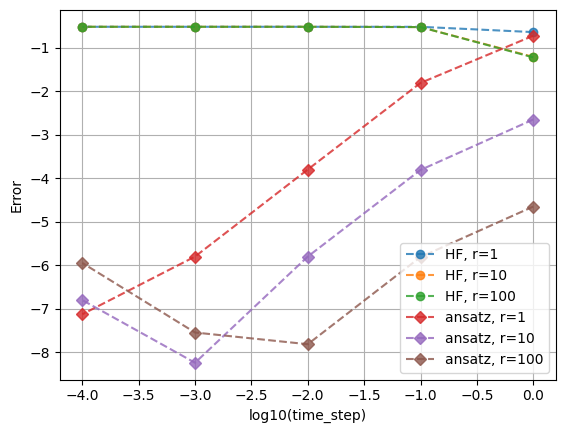

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
results = o_np.array(results)
for method_state in ["HF", "ansatz"]:
    tm = "o" if method_state == "HF" else "D"
    for trotter_step in [1, 10, 100]:
        mask = (results[:,0] == method_state) & (results[:,1] == str(trotter_step) )
        x = list(map(float, results[mask, 2]))
        y = list(map(float, results[mask, 4]))
        ax.plot(x, y, marker=tm, ls="dashed", label=f"{method_state}, r={trotter_step}", alpha=0.8)
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("log10(time_step)")
ax.set_ylabel("Error")
ax.legend()
ax.grid()
plt.show()

## QPE

pennylaneの[Intro to Quantum Phase Estimation](https://pennylane.ai/qml/demos/tutorial_qpe)も参考にしてみよう。

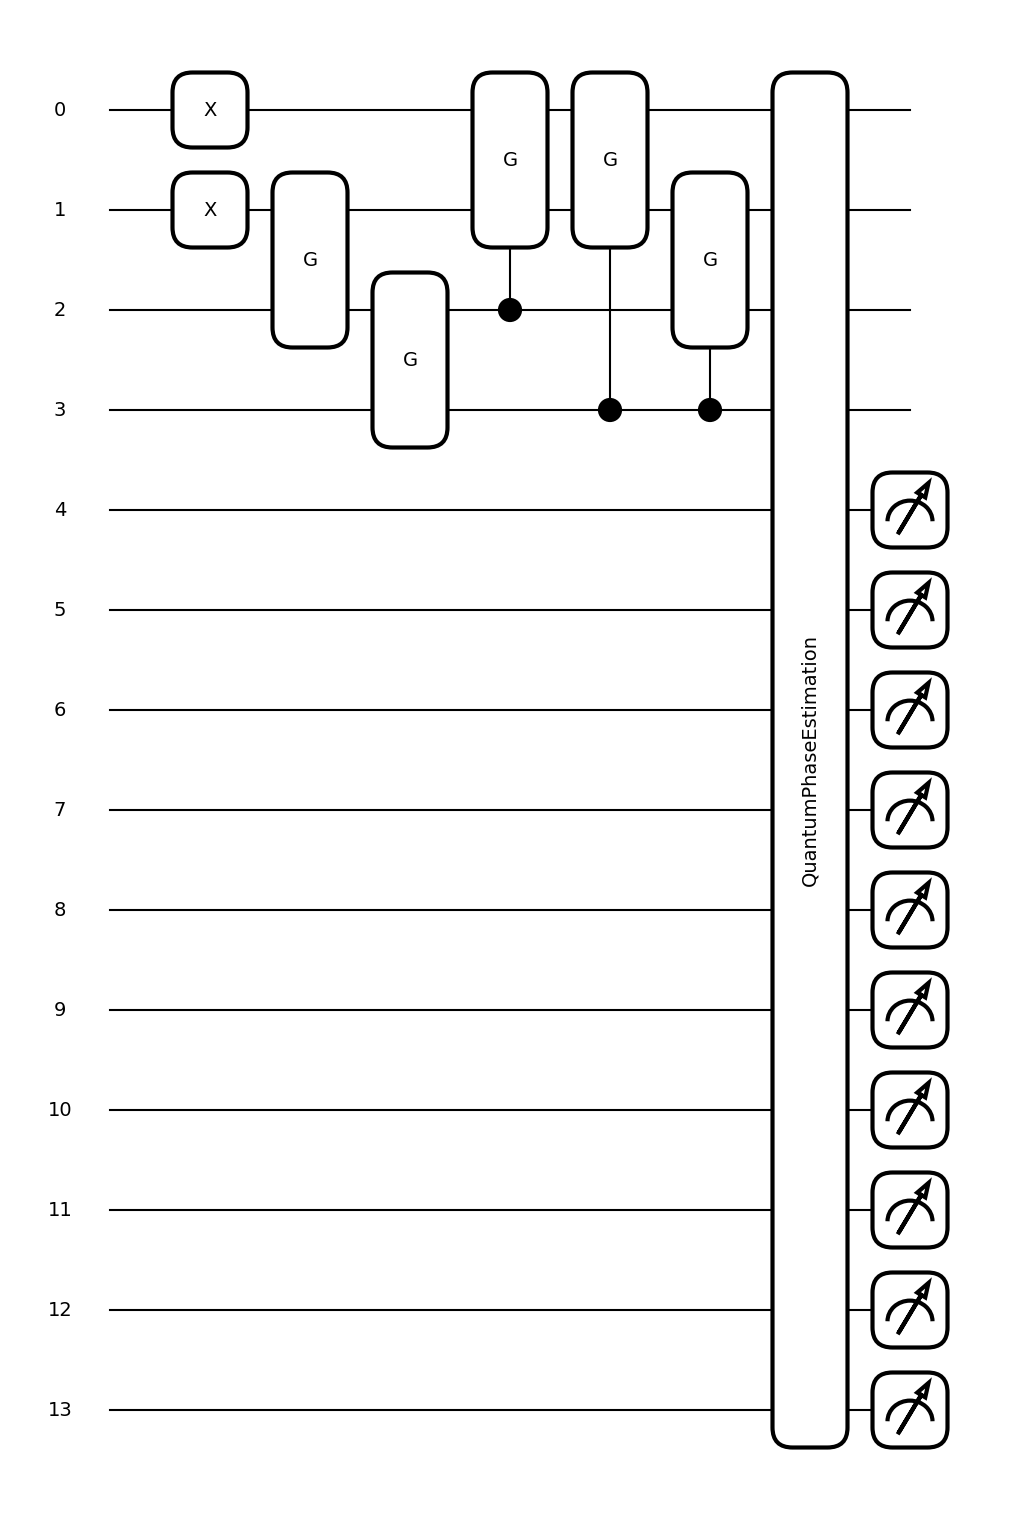

In [56]:
def float_from_binary(binary):
    return sum([int(x) * 2**(-i-1) for i, x in enumerate(binary[2:])])

n_ancilla = 10
dev = qml.device("default.qubit", wires=n_ancilla+Hamil.Norb)

@qml.qnode(dev)
def circuit_QPE(H_qubit, method_state="ansatz"):
    ancilla_wires = list(range(Norb, Norb+n_ancilla))
    # State preparation
    if method_state == "HF" or method_state == "ansatz":
        qml.PauliX(0)
        qml.PauliX(1)
    elif method_state == "Hadamard":
        for q in range(Norb):
            qml.Hadamard(wires=q)
    else:
        raise ValueError("method_state "+ method_state +" not implemented")
    if method_state == "ansatz":
        qml.SingleExcitation(params_exact[0], wires=[1,2])
        qml.SingleExcitation(params_exact[1], wires=[2,3])
        qml.ctrl(qml.SingleExcitation, control=[2])(params_exact[2], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[3], wires=[0,1])
        qml.ctrl(qml.SingleExcitation, control=[3])(params_exact[4], wires=[1,2])

    # Time Evolution 
    iHt = qml.TrotterProduct(H_qubit, n=trotter_step, time=time_step)
    Op = iHt

    # Quantum Phase Estimation
    QuantumPhaseEstimation(
        Op,
        estimation_wires=ancilla_wires,
    )
    return qml.probs(wires=ancilla_wires)

fig, ax  = qml.draw_mpl(circuit_QPE)(H_qubit)

In [47]:
method_state = "ansatz"
trotter_step = 20
time_step = 1.e-1
res = circuit_QPE(H_qubit, method_state)

In [48]:
ancilla_wires = list(range(Norb, Norb+n_ancilla))
bit_strings = [f"0.{x:0{len(ancilla_wires)}b}" for x in range(len(res))]

idx =  np.argmax(res)
bit_str = bit_strings[idx]
E_estimated = idx / 2**n_ancilla * 2 * o_np.pi / time_step
print(bit_str, "prob.", res[idx], "E_estimated", E_estimated, "Egs_exact", Egs_exact, "error", E_estimated - Egs_exact)

0.0000010011 prob. 0.5869441247214197 E_estimated 1.165825398793087 Egs_exact 1.1898518351360725 error -0.024026436342985402
